In [4]:
!pip install uszipcode
!pip install pandarallel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00
  Created wheel for atomicwrites: filename=atomicwrites-1.4.1-py2.py3-none-any.whl size=6941 sha256=16c0eeb6885847de4597c3632085cab506d72f5f641b6ac6ef105895924dc223
  Stored in directory: /root/.cache/pip/wheels/34/07/0b/33b15f68736109f72ea0bb2499521d87312b932620737447a2
Successfully built atomicwrites
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.28
    Uninstalling SQLAlchemy-2.0.28:
      Successfully uninstalled SQLAlchemy-2.0.28
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
from google.colab import drive
import datetime
from datetime import timedelta
from google.colab import drive
import time
import folium
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.geocoders import ArcGIS
import concurrent.futures
from geopy.distance import geodesic
from uszipcode import SearchEngine
from pandarallel import pandarallel

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/Session-Details-Summary-20240119-3.csv')
df_tn_reg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/TN_EV_Registrations.csv')
df_venue= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/lat_long_charging_venue.csv')


**Calculate the distance between  "driver ZIP code"  and   "Station ZIP code"**

---



In [8]:
missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Remove specified columns
columns_to_remove = ['Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude', 'Longitude']
df = df.drop(columns=columns_to_remove)

# Merge with venue information
df = pd.merge(df, df_venue[['EVSE ID', 'Charging Venue', 'Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude (y)', 'Longitude (x)']], on='EVSE ID', how='left')

In [9]:

# Initialize the Search Engine
search = SearchEngine()

# Initialize pandarallel
pandarallel.initialize()


zip_dict = {}

def get_lat_long(zip_code):
    if pd.isna(zip_code):
        return (None, None)
    if zip_code not in zip_dict:
        result = search.by_zipcode(zip_code)
        if result:
            zip_dict[zip_code] = (result.lat, result.lng)
        else:
            zip_dict[zip_code] = (None, None)  # Default value
    return zip_dict[zip_code]



def calculate_distance(row):
    try:
        # Get the lat, long for both zip codes
        loc1 = get_lat_long(row['Zip/Postal Code'])
        loc2 = get_lat_long(row['Driver Zip/Postal Code'])

        # If either location is None, return None
        if None in loc1 or None in loc2:
            return None


        return geodesic(loc1, loc2).miles
    except Exception as e:
        print(f"Error: {e}")
        return None


# Apply the function to your DataFrame
df['zip_dis'] = df.parallel_apply(calculate_distance, axis=1)
df['zip_dis'].fillna(df['zip_dis'].median(), inplace=True)



Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [10]:
def mean_excluding_zeros(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return np.mean(non_zero_values)
    else:
        return np.nan
#-----------------------------
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        if len(parts) >= 3:
            try:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2].split()[0])
                total_seconds = hours * 3600 + minutes * 60 + seconds
                return total_seconds
            except (IndexError, ValueError):
                print("Invalid duration format")
                return 0
        else:
            print("Invalid duration format")
            return 0
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0
#--------------------------------------------------------------------------------

def convert_to_est_old(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


time_zones = {
    'EST': 'America/New_York',
    'CST': 'America/Chicago',
    'CDT': 'America/Chicago',
    'EDT': 'America/New_York',
    'PDT': 'America/Los_Angeles',
    'PST': 'America/Los_Angeles'
}

# Convert time zones
def convert_to_est(row):
    est_tz = timezone('America/New_York')
    start_tz = timezone(time_zones[row['Start Time Zone']])
    end_tz = timezone(time_zones[row['End Time Zone']])

    row['Start Date'] = row['Start Date'].astimezone(start_tz).astimezone(est_tz)
    row['End Date'] = row['End Date'].astimezone(end_tz).astimezone(est_tz)

    return row

#--------------------------------------------------------------------------------

missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Apply function to Start and End Date
df['Start_Time_EST'] = pd.to_datetime(df['Start Date'])
df['End_Time_EST'] = pd.to_datetime(df['End Date'])
#df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
#df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

#sorting
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])


#    Total duration  Charging time   parking time   End charging Time

df['Total Duration'] = (df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
df['Charging Time'] = (df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
#df['Charging Time (dayTime)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']
df['parking_time'] = df['Total Duration'] - df['Charging Time']
df['End_Charging_Time_EST'] = [date + timedelta(hours=chargingtime) for date, chargingtime in df[['Start_Time_EST','Charging Time']].itertuples(index=False)]
#df['End_Charging_Time_EST_2']= df['Start_Time_EST'] +df['Charging Time (dayTime)']

# wich day of week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)
df['Port Type'] = df['Port Type'].fillna('')

#Cost --> cost_free: Binary variable indicating if the station offers free charging
#     ---> cost_paid: Binary variable indicating if the station offers paid charging
df['Fee'] = df['Fee'].fillna(0)
df['cost_free'] = (df['Fee'] == 0).astype(int)
df['cost_paid'] = (df['Fee'] > 0).astype(int)

# Add VENUE features


#['Office', 'Leisure', 'Library', 'Hotel', 'Retail', 'Parking',
# 'Education', 'Medical', 'Citty Hall', 'GAS Station']
#ven_hotel:     Binary variable indicating if the station venue is a hotel
#ven_leisure:   Binary variable indicating if the station venue is a leisure destination
#ven_med_ed:    Binary variable indicating if the station venue is a medical or educational campus
#ven_muni:      Binary variable indicating if the station venue is a municipal building
#ven_office:    Binary variable indicating if the station venue is an office building
#ven_parking:   Binary variable indicating if the station venue is a parking lot or garage
#ven_retail:    Binary variable indicating if the station venue is a retail location
#ven_transit:   Binary variable indicating if the station venue is a transit facility

df['ven_hotel'] = (df['Charging Venue'] == 'Hotel').astype(int)
df['ven_leisure'] = (df['Charging Venue'] == 'Leisure').astype(int)
df['ven_med_ed'] = ((df['Charging Venue'] == 'Medical') | (df['Charging Venue'] == 'Medical' )).astype(int)
df['ven_muni'] = (df['Charging Venue'] == 'Citty Hall').astype(int)
df['ven_office'] = (df['Charging Venue'] == 'Office').astype(int)
df['ven_parking'] = (df['Charging Venue'] == 'Parking').astype(int)
df['ven_retail'] = (df['Charging Venue'] == 'Retail').astype(int)
df['ven_transit'] = (df['Charging Venue'] == 'Transit').astype(int)



#sorting data
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])

# idle time
#df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
#df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby(['EVSE ID','Port Number'])['End_Time_EST'].shift(1)
df['idle'] = df['Start_Time_EST'] - df['previous_end_time']
df['idle_hour']= (df['idle'].dt.total_seconds())/3600
df['idle_day']= (df['idle'].dt.total_seconds())/86400

# Calculate SOC difference
df['Start SOC'] = df['Start SOC'].str.replace('%', '').fillna(0).astype('int64')
df['End SOC'] = df['End SOC'].str.replace('%', '').fillna(0).astype('int64')
df['SOC_diff'] = df['End SOC'] - df['Start SOC']
mean_soc_diff_without_zeros = df[df['SOC_diff'] != 0]['SOC_diff'].mean()


#sorting df
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df.reset_index(drop=True, inplace=True)

####   Normalization based on service  #####
evse_service_time = df.groupby('EVSE ID').agg({'Start_Time_EST': 'min', 'End_Time_EST': 'max'})
evse_service_time['Service_Days'] = (evse_service_time['End_Time_EST'] - evse_service_time['Start_Time_EST']).dt.days
evse_service_time.reset_index(inplace=True)
df = pd.merge(df, evse_service_time[['EVSE ID', 'Service_Days']], on='EVSE ID', how='left')

df['Event Count'] = df.groupby('EVSE ID')['EVSE ID'].transform('count')
df['Normalized Event Count'] = df['Event Count'] / df['Service_Days']


###  Utilizatiion Rate   ####
unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique()
total_charging_time_evse=df.groupby('EVSE ID')['Charging Time'].sum()

utilization_data = pd.DataFrame({
    'EVSE ID': unique_ports_per_evse.index,
    'Number of Ports': unique_ports_per_evse.values,
    'Total Charging Time (hours)': total_charging_time_evse,
    'Service Days': df.groupby('EVSE ID')['Service_Days'].max()

})

#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
utilization_data['Total Available Time (hours)'] = utilization_data['Number of Ports'] * utilization_data['Service Days'] * 24

# Calculate the utilization rate
utilization_data['Utilization Rate'] = utilization_data['Total Charging Time (hours)'] / utilization_data['Total Available Time (hours)']

#---------------------------------------------------------------------------------------------------------------------

####   DC and L2 df  ####
df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]

# TN State
df_TN=df[df['State/Province']=='Tennessee']

#  **Daily Usage**

In [16]:
#Station utilization: The average energy delivered by a station during a time period divided by the number of ports a

#df = df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Date'] = df['Start_Time_EST'].dt.date

unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique().reset_index()
daily_usage_evse = df.groupby(['EVSE ID', 'Date'])['Energy (kWh)'].sum().reset_index()
daily_charging_time_evse=df.groupby(['EVSE ID', 'Date'])['Charging Time'].sum().reset_index()
daily_fee_evse=df.groupby(['EVSE ID', 'Date'])['Fee'].sum().reset_index()


# Calculate the number of charging events per day per EVSE ID
daily_events = df.groupby(['EVSE ID', 'Date']).size().reset_index()
daily_events.columns = ['EVSE ID', 'Date', 'Number of Events']

#   average daily basis in kilowatt-hours per port per day
#   Create utilization_station_data DataFrame
utilization_station_data = pd.merge(unique_ports_per_evse, daily_usage_evse, on='EVSE ID', how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_events, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_charging_time_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_fee_evse, on=['EVSE ID', 'Date'], how='left')

# Create new columns 'Is_Weekday' and 'Is_Weekend'
utilization_station_data['Day_of_Week'] = pd.to_datetime(utilization_station_data['Date']).dt.dayofweek
utilization_station_data['Is_Weekday'] = utilization_station_data['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
utilization_station_data['Is_Weekend'] = utilization_station_data['Day_of_Week'].isin([5, 6]).astype(int)



merged_df = df[['EVSE ID', 'Charging Venue', 'City', 'Station Name', 'Address 1', 'State/Province',
                                                   'Zip/Postal Code', 'Latitude (y)', 'Longitude (x)', 'Port Type']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df, on='EVSE ID', how='left')

utilization_station_data['Util_station (kWh/port/day)'] = utilization_station_data['Energy (kWh)']/ utilization_station_data['Port Number']

# Specify the columns you want to sum
columns_to_sum = ['Energy (kWh)', 'Charging Time', 'Fee', 'GHG Savings (kg)', 'Gasoline Savings (gallons)']
daily_usage_evse = df.groupby(['EVSE ID', df['Start_Time_EST'].dt.date])[columns_to_sum].sum().reset_index()



# Charging Venue

utilization_station_data['ven_hotel'] = (utilization_station_data['Charging Venue'] == 'Hotel').astype(int)
utilization_station_data['ven_leisure'] = (utilization_station_data['Charging Venue'] == 'Leisure').astype(int)
utilization_station_data['ven_med_ed'] = ((utilization_station_data['Charging Venue'] == 'Medical') | (utilization_station_data['Charging Venue'] == 'Medical' )).astype(int)
utilization_station_data['ven_muni'] = (utilization_station_data['Charging Venue'] == 'Citty Hall').astype(int)
utilization_station_data['ven_office'] = (utilization_station_data['Charging Venue'] == 'Office').astype(int)
utilization_station_data['ven_parking'] = (utilization_station_data['Charging Venue'] == 'Parking').astype(int)
utilization_station_data['ven_retail'] = (utilization_station_data['Charging Venue'] == 'Retail').astype(int)
utilization_station_data['ven_transit'] = (utilization_station_data['Charging Venue'] == 'Transit').astype(int)

# CDC or L2

utilization_station_data['DC'] = (utilization_station_data['Port Type'] == 'DC Fast').astype(int)
utilization_station_data['L2'] = (utilization_station_data['Port Type'] == 'Level 2').astype(int)

# Cost free or paid
utilization_station_data['cost_free'] = (utilization_station_data['Fee'] == 0).astype(int)
utilization_station_data['cost_paid'] = (utilization_station_data['Fee'] > 0).astype(int)


In [17]:
utilization_station_data

,EVSE ID,Port Number,Date,Energy (kWh),Number of Events,Charging Time,Fee,Day_of_Week,Is_Weekday,Is_Weekend,...,ven_med_ed,ven_muni,ven_office,ven_parking,ven_retail,ven_transit,DC,L2,cost_free,cost_paid
0,682921,2,2018-10-31,0.000,2,0.000000,0.00,2,1,0,...,0,0,1,0,0,0,0,1,1,0
1,682921,2,2018-11-05,0.000,1,0.000000,0.00,0,1,0,...,0,0,1,0,0,0,0,1,1,0
2,682921,2,2018-11-06,30.584,3,4.806111,0.00,1,1,0,...,0,0,1,0,0,0,0,1,1,0
3,682921,2,2018-11-09,24.547,1,3.846667,0.00,4,1,0,...,0,0,1,0,0,0,0,1,1,0
4,682921,2,2018-11-13,0.000,5,0.000000,0.00,1,1,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20500,15250771,1,2023-12-30,52.354,1,0.737222,21.99,5,0,1,...,0,0,0,1,0,0,1,0,0,1
20501,15250771,1,2024-01-01,11.990,1,0.224722,5.04,0,1,0,...,0,0,0,1,0,0,1,0,0,1
20502,15250771,1,2024-01-17,0.000,1,0.005833,0.00,2,1,0,...,0,0,0,1,0,0,1,0,1,0
20503,15293211,1,2023-12-27,0.000,1,0.000000,0.00,2,1,0,...,0,0,0,0,0,0,0,1,1,0


#  **Daily Usage**

In [27]:
utilization_station_data

,EVSE ID,Port Number,Date,Energy (kWh),Charging Time,Fee,GHG Savings (kg),Gasoline Savings (gallons),Number of Events,Charging Venue,...,ven_office,ven_parking,ven_retail,ven_transit,ven_med_ed,ven_muni,DC,L2,cost_free,cost_paid
0,682921,2,2018-10-31,0.000,0.000000,0.0,0.000,0.000,2,Office,...,1,0,0,0,0,0,0,1,1,0
1,682921,2,2018-11-05,0.000,0.000000,0.0,0.000,0.000,1,Office,...,1,0,0,0,0,0,0,1,1,0
2,682921,2,2018-11-06,0.000,0.000000,0.0,0.000,0.000,3,Office,...,1,0,0,0,0,0,0,1,1,0
3,682921,2,2018-11-09,0.000,0.000000,0.0,0.000,0.000,1,Office,...,1,0,0,0,0,0,0,1,1,0
4,682921,2,2018-11-13,0.000,0.000000,0.0,0.000,0.000,5,Office,...,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9859538,15250771,1,2024-01-17,0.000,0.005833,0.0,0.000,0.000,1,Parking,...,0,1,0,0,0,0,0,0,1,0
9859539,15293211,1,2023-12-27,0.000,0.000000,0.0,0.000,0.000,1,Education,...,0,0,0,0,0,0,0,0,1,0
9859540,15293211,1,2024-01-13,0.000,0.000000,0.0,0.000,0.000,1,Education,...,0,0,0,0,0,0,0,0,1,0
9859541,15293211,1,2023-12-27,54.509,9.441389,0.0,41.209,6.841,1,Education,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#columns=['Station Name','EVSE ID', 'Org Name', 'Address 1', 'City', 'State/Province', 'Zip/Postal Code', 'Latitude','Longitude']
#df_location=df[columns]
#uniue_evse_loc=df_location.drop_duplicates(subset=['EVSE ID'])
#uniue_evse_loc.to_excel('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/lat_lot.xlsx')

In [ ]:
count_117 = (df['parking_time'] > .0325).sum()
count_15_min_more = (df['parking_time'] > .25).sum()
count_60_min_more = (df['parking_time'] > 1).sum()
count_120_min_more = (df['parking_time'] > 2).sum()

print(f"Number of parking time with more than 117 sec: {count_117}")
print(f"Number of parking time with more than 900 sec- 15min: {count_15_min_more}")
print(f"Number of parking time with more than 3600 sec- 60min: {count_60_min_more}")
print(f"Number of parking time with more than 120 min: {count_120_min_more}")

Number of parking time with more than 117 sec: 8696
Number of parking time with more than 900 sec- 15min: 4949
Number of parking time with more than 3600 sec- 60min: 3169
Number of parking time with more than 120 min: 2310


In [ ]:
negative_time_differences = df[df['previous_end_time'] > df['Start_Time_EST']]
num_negative_time_differences = len(negative_time_differences)
print("Number of cases where previous_end_time > Start_Time_EST:", num_negative_time_differences)

Number of cases where previous_end_time > Start_Time_EST: 25


In [ ]:
#columns = ['Station Name', 'EVSE ID', 'MAC Address', 'Org Name', 'Address 1', 'City', 'State/Province',
       #    'Zip/Postal Code', 'Driver Zip/Postal Code', 'User ID', 'Latitude', 'Longitude', 'Port Type', "DC", "L2" ,
       #    'Start_Time_EST','End_charging_time', 'End_Time_EST', 'time_difference_session','Total Duration','Charging Time',
       #    'Time_Difference',"previous_end_time","Is_Weekday","Is_Weekend", 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)',
       #    'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Fee', 'Start SOC', 'End SOC',
       #    'System S/N', 'Model Number', 'Vehicle MAC ID','Port Number','Plug Type', 'Ended By']

# Create a new DataFrame for ML
#df = df[columns]

In [ ]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/sorted_df.csv', index=False)

In [ ]:
df[df['Port Type'] == 'Level 2'].describe()

,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),EVSE ID,Zip/Postal Code,Latitude,Longitude,Fee,Plug In Event ID,Transaction ID,...,Is_Weekend,DC,L2,idle,idle_hour,Service_Days,Event Count,Normalized Event Count,EVSE_Energy_Count,Normalized Energy
count,21490.000000,21490.000000,21490.000000,2.149000e+04,21490.000000,21490.000000,21490.000000,21490.000000,2.149000e+04,2.149000e+04,...,21490.000000,21490.0,21490.0,21399,21399.000000,21490.000000,21490.000000,21490.000000,21490.000000,21490.000000
mean,14.480026,9.803970,1.817247,4.338627e+06,37568.681480,35.159909,-85.441957,2.354865,3.559515e+08,1.559868e+09,...,0.288692,0.0,1.0,4 days 04:37:15.556661526,100.620988,1346.545928,1035.072127,0.750599,15027.871029,10.670593
std,15.772124,11.015108,1.979405,3.523846e+06,1517.495025,1.027246,2.037208,4.045365,6.802328e+08,7.119201e+08,...,0.453165,0.0,0.0,11 days 16:26:09.778757921,280.436050,376.662827,579.143780,0.363649,8842.494965,5.232732
min,0.000000,0.000000,0.000000,6.829210e+05,35055.000000,33.441528,-89.494995,0.000000,1.000000e+00,3.215062e+08,...,0.000000,0.0,1.0,-1 days +21:20:26,-2.659444,17.000000,2.000000,0.025719,54.509000,0.327010
25%,3.434000,2.137250,0.431000,1.921531e+06,35976.000000,34.360722,-86.804886,0.000000,1.550000e+02,9.671346e+08,...,0.000000,0.0,1.0,0 days 10:03:13.500000,10.053750,1117.000000,527.000000,0.414272,6081.485000,5.892343
50%,9.122000,5.896000,1.145000,1.988141e+06,37601.000000,35.040119,-85.703247,1.000000,4.350000e+02,1.429675e+09,...,0.000000,0.0,1.0,1 days 01:04:29,25.074722,1520.000000,1173.000000,0.838816,16393.478000,13.170292
75%,19.714000,13.157750,2.474000,5.525971e+06,37902.000000,35.962002,-83.536514,2.910000,1.093000e+03,2.120054e+09,...,1.000000,0.0,1.0,3 days 10:09:38.500000,82.160694,1580.000000,1431.000000,0.937533,22170.480000,14.837549
max,132.377000,93.988000,16.613000,1.529321e+07,42754.000000,37.482788,-82.187943,95.950000,1.705648e+09,2.853091e+09,...,1.000000,0.0,1.0,325 days 17:38:31,7817.641944,1905.000000,1934.000000,1.350126,27777.551000,17.193797


In [ ]:
df[df['Port Type'] == 'DC Fast'].describe()

,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),EVSE ID,Zip/Postal Code,Latitude,Longitude,Fee,Plug In Event ID,Transaction ID,...,Day_of_Week,Is_Weekday,Is_Weekend,DC,L2,idle,idle_hour,Service_Days,Event Count,Normalized Event Count
count,15453.000000,15453.000000,15453.000000,1.545300e+04,15453.000000,15453.000000,15453.000000,15453.000000,1.545300e+04,1.545300e+04,...,15451.000000,15453.000000,15453.000000,15453.0,15453.0,15357,15357.000000,15453.000000,15453.000000,15453.000000
mean,24.437397,17.492105,3.066892,1.017964e+07,37246.748851,35.516976,-85.767682,8.889573,4.317884e+08,2.177152e+09,...,3.230535,0.668155,0.331716,1.0,0.0,1 days 14:04:01.214625252,38.067004,622.071378,954.562156,1.489207
std,19.975826,14.366418,2.506968,3.779642e+06,2398.668142,1.044211,1.965681,7.911526,7.349525e+08,5.989340e+08,...,1.991029,0.470891,0.470845,0.0,0.0,5 days 04:44:08.947432681,124.735819,354.578899,653.362559,0.692415
min,0.000000,0.000000,0.000000,2.118081e+06,30512.000000,34.208065,-89.519547,0.000000,1.000000e+00,7.154520e+08,...,0.000000,0.000000,0.000000,1.0,0.0,-1 days +23:41:57,-0.300833,12.000000,2.000000,0.166667
25%,7.912000,5.594000,0.993000,5.354011e+06,35967.000000,34.444214,-86.875031,2.550000,1.540000e+02,1.643032e+09,...,2.000000,0.000000,0.000000,1.0,0.0,0 days 01:09:15,1.154167,253.000000,278.000000,0.780702
50%,22.391000,15.970000,2.810000,1.240640e+07,37745.000000,35.867615,-85.718971,7.400000,5.410000e+02,2.508224e+09,...,3.000000,1.000000,0.000000,1.0,0.0,0 days 10:24:54,10.415000,618.000000,978.000000,1.675307
75%,37.616000,26.877000,4.721000,1.360606e+07,38237.000000,36.325130,-83.564766,13.470000,1.627133e+09,2.704977e+09,...,5.000000,1.000000,1.000000,1.0,0.0,1 days 03:43:01,27.716944,885.000000,1231.000000,1.901381
max,168.902000,126.108000,21.197000,1.525077e+07,42320.000000,37.377178,-82.261505,70.060000,1.705690e+09,2.853105e+09,...,6.000000,1.000000,1.000000,1.0,0.0,143 days 21:18:39,3453.310833,1303.000000,2164.000000,2.445198


In [ ]:
df_L2_evse_summary = df_L2.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'Total Duration' : 'mean', 'Plug In Event ID' : 'count'}).reset_index()
df_DC_evse_summary = df_DC.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'Total Duration' : 'mean', 'Plug In Event ID' : 'count'}).reset_index()

In [ ]:
df_evse_summary = df.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'Total Duration' : 'mean', 'Plug In Event ID' : 'count'}).reset_index()
fig = px.scatter(df_evse_summary, x='Total Duration', y='Plug In Event ID', color='Port Type', hover_data=['EVSE ID','Address 1','City','State/Province'])

fig.update_layout(
    title='Total duration vs No. of Session for each CS',
    xaxis_title='Total duration: Charging + Parking (hours)',
    yaxis_title='Number of Session',
)

fig.show()

In [ ]:
df__l2_evse_summary = df_L2.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'Total Duration' : 'mean', 'Plug In Event ID' : 'count'}).reset_index()
fig = px.scatter(df__l2_evse_summary, x='Total Duration', y='Plug In Event ID', color='Port Type', hover_data=['EVSE ID','Address 1','City','State/Province'])

fig.update_layout(
    title='Level2 charging station total duration vs No. of Session for each CS',
    xaxis_title='Total duration: Charging + Parking (hours)',
    yaxis_title='Number of Session',
)

fig.show()

In [ ]:
df_DC_evse_summary = df_DC.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'Total Duration' : 'mean', 'Plug In Event ID' : 'count'}).reset_index()
color_discrete_map = {'Port Type': 'red'}

fig = px.scatter(df_DC_evse_summary, x='Total Duration', y='Plug In Event ID', color='Port Type', hover_data=['EVSE ID','Address 1','City','State/Province'],color_discrete_map=color_discrete_map)



fig.update_layout(
    title='DC Fast charging station total duration vs No. of Session for each CS',
    xaxis_title='Total duration: Charging + Parking (hours)',
    yaxis_title='Number of Session',

)

fig.show()

In [ ]:
df_evse_summary_charging = df.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'Charging Time' : 'mean', 'Energy (kWh)': 'mean', 'Plug In Event ID' : 'count'}).reset_index()
fig = px.scatter(df_evse_summary_charging,
                 x='Charging Time',
                 y='Plug In Event ID',
                 color='Port Type',
                 size='Energy (kWh)',
                hover_data=['EVSE ID','Address 1','City','State/Province'])
fig.update_layout(
    title='Charging Time vs No. of Session for each CS, Size: The average of deliverd energy (kWh)',
    xaxis_title='Charging Time (hours)',
    yaxis_title='Number of Session',
)
fig.show()

In [ ]:

def mean_excluding_zeros(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return np.mean(non_zero_values)
    else:
        return np.nan

df_evse_summary_parking_idle = df.groupby(['EVSE ID', 'Port Type', 'Address 1', 'City', 'State/Province'], as_index=False).agg({'Charging Time': 'mean',
                                                                                                                                    'Plug In Event ID': 'count',
                                                                                                                                    'SOC_diff': mean_excluding_zeros}).reset_index()
df_evse_summary_parking_idle['SOC_diff'].fillna(0, inplace=True)

df_level_2 = df_evse_summary_parking_idle[df_evse_summary_parking_idle['Port Type'] == 'DC Fast']

color_discrete_map = {'Port Type': 'red'}
fig = px.scatter(df_level_2,
                 x='Charging Time',
                 y='SOC_diff',
                 color='Port Type',
                 hover_data=['EVSE ID', 'Address 1', 'City', 'State/Province'],
                 color_discrete_map=color_discrete_map)

fig.update_layout(
    title='Charging Time vs SOC delivered energy (kWh)',
    xaxis_title='Charging Time (hours)',
    yaxis_title='Difference between END SOC and Start SOC',
)

fig.show()

In [ ]:
parking_idle = df.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'parking_time' : 'mean', 'idle_day': 'mean'}).reset_index()

fig = px.scatter(parking_idle,
                 x='parking_time',
                 y='idle_day',
                 color='Port Type',
                 hover_data=['EVSE ID','Address 1','City','State/Province'])


fig.update_layout(
    title='Parking Time vs Idle Day Scatter Plot',
    xaxis_title='Parking Time (hours)',
    yaxis_title='Idle time (day)',
)

fig.show()

In [ ]:
parking_idle_dc = df_DC.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'parking_time' : 'mean', 'idle_day': 'mean'}).reset_index()

color_discrete_map = {'Port Type': 'red'}
fig = px.scatter(parking_idle_dc,
                 x='parking_time',
                 y='idle_day',
                 color='Port Type',
                 hover_data=['EVSE ID','Address 1','City','State/Province'],
                 color_discrete_map=color_discrete_map)


fig.update_layout(
    title='Parking Time vs Idle Day Scatter Plot (DC Fast charging)',
    xaxis_title='Parking Time (hours)',
    yaxis_title='Idle time (day)',
)

fig.show()

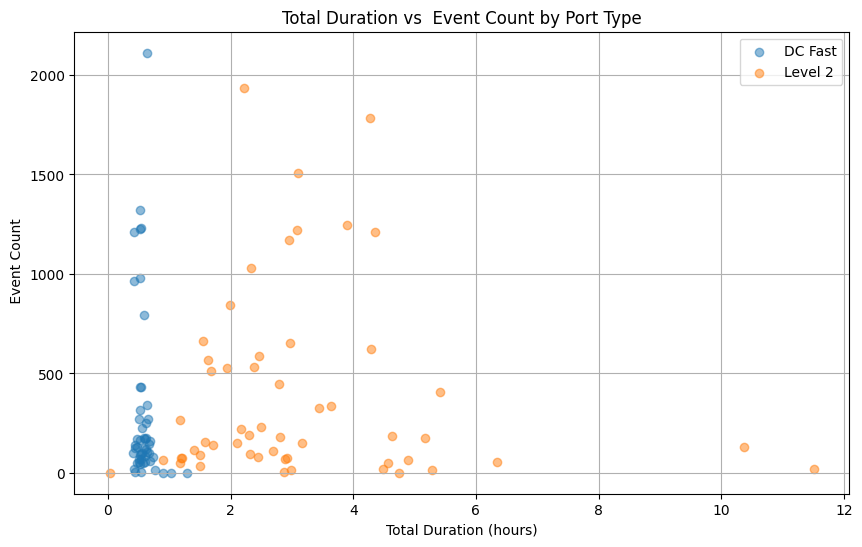

In [ ]:
plt.figure(figsize=(10, 6))
for port_type, data in df_evse_summary.groupby('Port Type'):
    plt.scatter(data['Total Duration'], data['Normalized Event Count'], label=port_type, alpha=0.5)
plt.title('Total Duration vs  Event Count by Port Type')
plt.xlabel('Total Duration (hours)')
plt.ylabel(' Event Count')
plt.legend()
plt.grid(True)
plt.show()


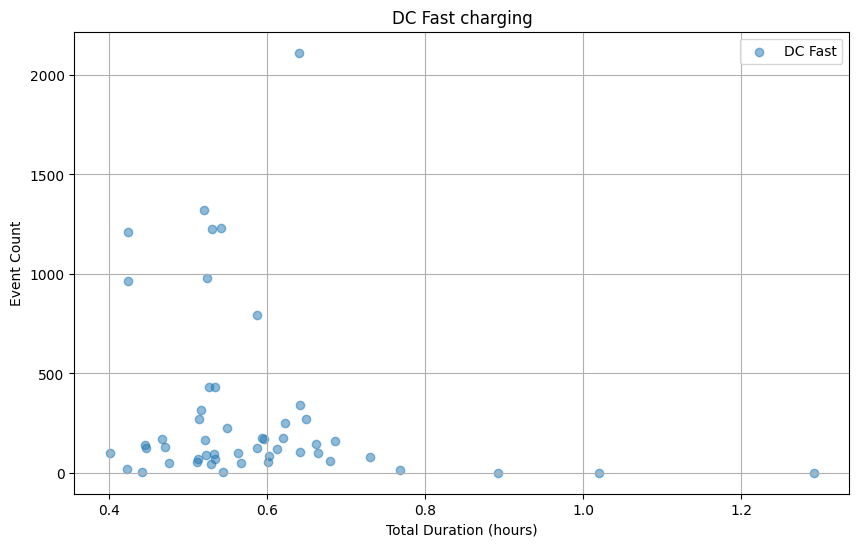

In [ ]:
plt.figure(figsize=(10, 6))
for port_type, data in df_DC_evse_summary.groupby('Port Type'):
    plt.scatter(data['Total Duration'], data['Normalized Event Count'], label=port_type, alpha=0.5)
plt.title('DC Fast charging')
plt.xlabel('Total Duration (hours)')
plt.ylabel('Event Count')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df.sort_values(by='End_Time_EST').groupby(['EVSE ID','Port Number'], as_index=False).nth(range(4))[['EVSE ID','Port Number','previous_end_time','Start_Time_EST','End_Time_EST']]

,EVSE ID,Port Number,previous_end_time,Start_Time_EST,End_Time_EST
0,682921,1,NaT,2018-10-31 15:02:22-05:00,2018-10-31 15:02:39-05:00
1,682921,1,2018-10-31 15:02:39-05:00,2018-10-31 15:04:34-05:00,2018-10-31 15:04:38-05:00
2,682921,1,2018-10-31 15:04:38-05:00,2018-11-05 08:54:12-05:00,2018-11-05 08:54:29-05:00
3,682921,1,2018-11-05 08:54:29-05:00,2018-11-06 09:49:44-05:00,2018-11-06 12:42:42-05:00
4,682921,2,NaT,2018-11-06 13:00:11-05:00,2018-11-06 14:55:52-05:00
...,...,...,...,...,...
36131,13966051,1B,NaT,2024-01-02 08:37:06-05:00,2024-01-02 08:58:25-05:00
36898,14337501,1A,2023-12-30 15:00:36-05:00,2024-01-11 18:28:25-05:00,2024-01-11 19:51:06-05:00
36929,15250701,1B,2023-12-24 13:14:39-05:00,2024-01-12 12:14:04-05:00,2024-01-12 13:26:50-05:00
36555,14049761,1B,NaT,2024-01-13 13:32:53-05:00,2024-01-13 13:50:51-05:00


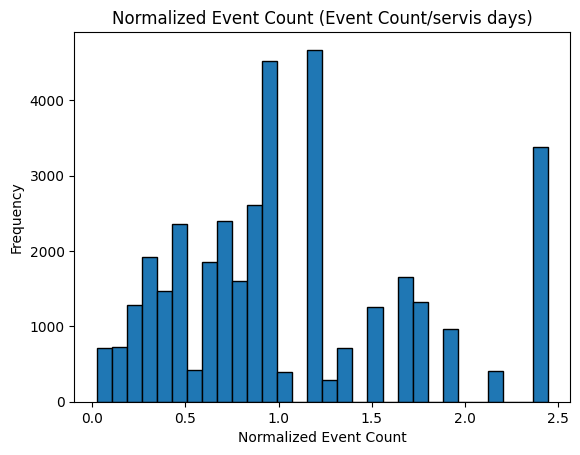

In [ ]:
plt.hist(df['Normalized Event Count'], bins=30, edgecolor='black')
plt.title('Normalized Event Count (Event Count/servis days)')
plt.xlabel('Normalized Event Count')
plt.ylabel('Frequency')
plt.show()


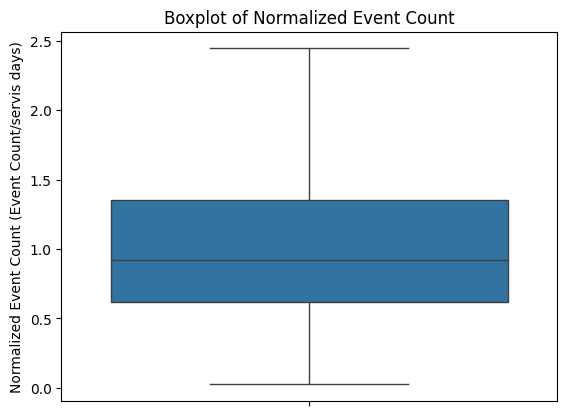

In [ ]:
sns.boxplot(y=df['Normalized Event Count'])
plt.title('Boxplot of Normalized Event Count')
plt.ylabel('Normalized Event Count (Event Count/servis days)')
plt.show()


## Calculate the *mean* 'Normalized Event Count' for each 'Station Name'

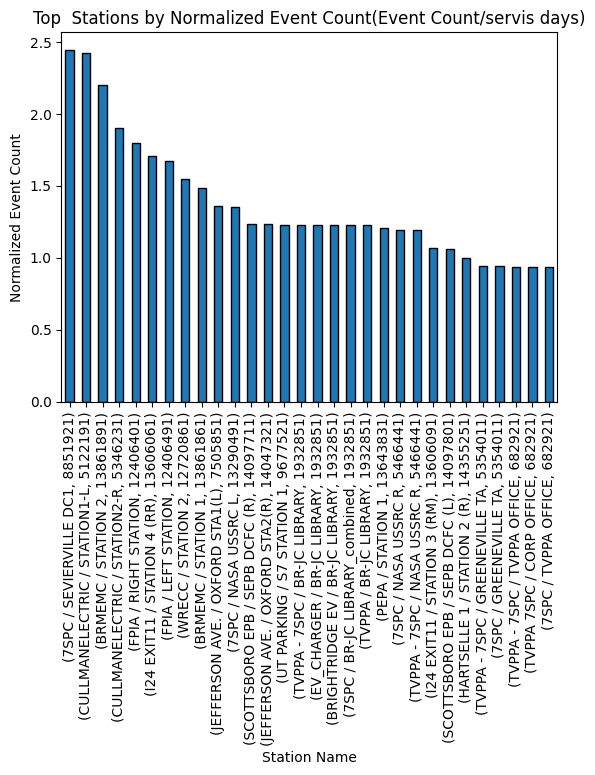

In [ ]:
station_event_count = df.groupby(['Station Name','EVSE ID'])['Normalized Event Count'].mean()
top_stations = station_event_count.sort_values(ascending=False).head(30)
top_stations.plot(kind='bar', edgecolor='black')
plt.title('Top  Stations by Normalized Event Count(Event Count/servis days)')
plt.xlabel('Station Name')
plt.ylabel('Normalized Event Count')
plt.show()

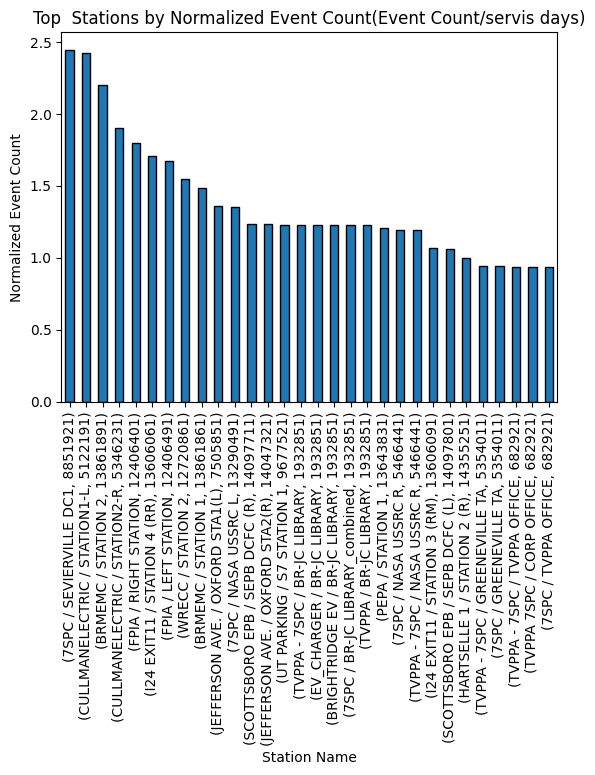

In [ ]:
station_DC_event_count = df_DC.groupby(['Station Name','EVSE ID'])['Normalized Event Count'].mean()
top_stations = station_event_count.sort_values(ascending=False).head(30)
top_stations.plot(kind='bar', edgecolor='black')
plt.title('Top  Stations by Normalized Event Count(Event Count/servis days)')
plt.xlabel('Station Name')
plt.ylabel('Normalized Event Count')
plt.show()

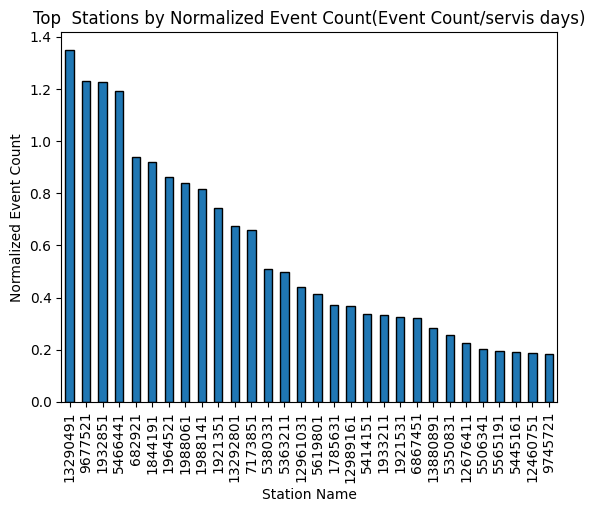

In [ ]:
station_L2_event_count = df_L2.groupby(['EVSE ID'])['Normalized Event Count'].mean()
top_stations = station_L2_event_count.sort_values(ascending=False).head(30)
top_stations.plot(kind='bar', edgecolor='black')
plt.title('Top  Stations by Normalized Event Count(Event Count/servis days)')
plt.xlabel('Station Name')
plt.ylabel('Normalized Event Count')
plt.show()

# **Utilization Rate**

In [ ]:
unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique()
total_charging_time_evse=df.groupby('EVSE ID')['Charging Time'].sum()

utilization_data = pd.DataFrame({
    'EVSE ID': unique_ports_per_evse.index,
    'Number of Ports': unique_ports_per_evse.values,
    'Total Charging Time (hours)': total_charging_time_evse,
    'Service Days': df.groupby('EVSE ID')['Service_Days'].max()
})

#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
utilization_data['Total Available Time (hours)'] = utilization_data['Number of Ports'] * utilization_data['Service Days'] * 24

# Calculate the utilization rate
utilization_data['Utilization Rate'] = utilization_data['Total Charging Time (hours)'] / utilization_data['Total Available Time (hours)']

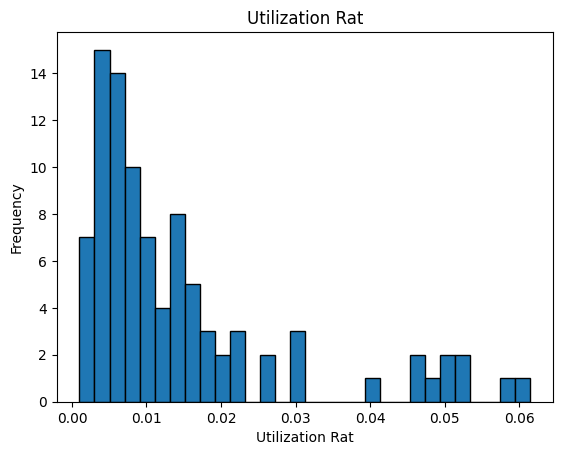

In [ ]:
plt.hist(utilization_data['Utilization Rate'], bins=30, edgecolor='black')
plt.title('Utilization Rat')
plt.xlabel('Utilization Rat')
plt.ylabel('Frequency')
plt.show()

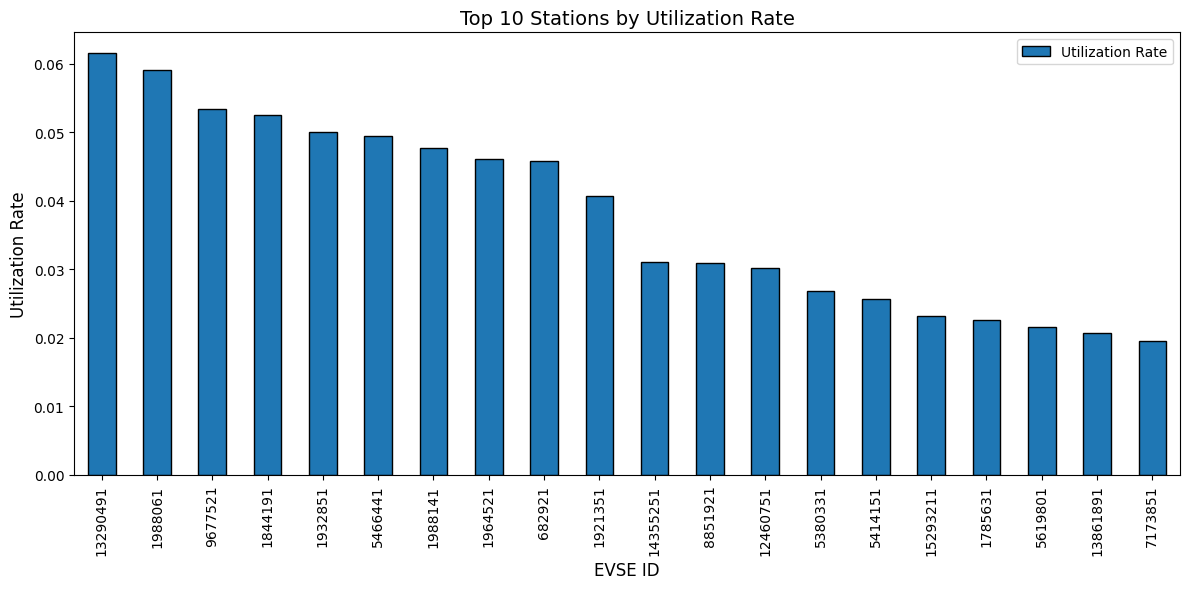

In [ ]:
utilization_data = utilization_data.sort_values(by='Utilization Rate', ascending=False)

# Select the top 10 stations by utilization rate
top_10_stations_utilization = utilization_data.head(20)


top_10_stations_utilization.plot(kind='bar', x='EVSE ID', y='Utilization Rate', edgecolor='black', figsize=(12, 6))
plt.title('Top 10 Stations by Utilization Rate', fontsize=14)
plt.xlabel('EVSE ID', fontsize=12)
plt.ylabel('Utilization Rate', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:

utilization_data = utilization_data.sort_values(by='Utilization Rate', ascending=False)
top_10_stations_utilization = utilization_data.head(10)['EVSE ID'].tolist()


station_event_count = df.groupby(['Station Name', 'EVSE ID'])['Normalized Event Count'].mean()
top_stations = station_event_count.sort_values(ascending=False)

top_10_stations_event_count = top_stations.head(10).index.get_level_values('EVSE ID').tolist()


if set(top_10_stations_utilization) == set(top_10_stations_event_count):
    print("The top 10 stations by utilization rate are the same as the top 10 stations by normalized event count.")
else:
    print("The top 10 stations by utilization rate are different from the top 10 stations by normalized event count.")


    common_stations = set(top_10_stations_utilization).intersection(set(top_10_stations_event_count))
    unique_utilization = set(top_10_stations_utilization).difference(common_stations)
    unique_event_count = set(top_10_stations_event_count).difference(common_stations)

    print(f"Common stations: {common_stations}")
    print(f"Unique stations by utilization rate: {unique_utilization}")
    print(f"Unique stations by normalized event count: {unique_event_count}")

The top 10 stations by utilization rate are different from the top 10 stations by normalized event count.
Common stations: set()
Unique stations by utilization rate: {1921351, 5466441, 1964521, 682921, 1988141, 9677521, 1932851, 13290491, 1988061, 1844191}
Unique stations by normalized event count: {12406401, 13861891, 13861861, 7505851, 13606061, 5122191, 8851921, 5346231, 12406491, 12720861}


In [ ]:
average_lat = df['Latitude'].mean()
average_long = df['Longitude'].mean()
map_dispaly = folium.Map(location=[average_lat, average_long], zoom_start=13)

# Add the top 10 stations by utilization rate to the map ----> RED
for evse_id in unique_utilization:
    station = df[df['EVSE ID'] == evse_id]
    lat = station['Latitude'].values[0]
    lon = station['Longitude'].values[0]
    folium.Marker([lat, lon], popup=f'EVSE ID: {evse_id}', icon=folium.Icon(color='red')).add_to(map_dispaly)

# Add the top 10 stations by normalized event count to the map ---> BLUE
for evse_id in unique_event_count:
    station = df[df['EVSE ID'] == evse_id]
    lat = station['Latitude'].values[0]
    lon = station['Longitude'].values[0]
    folium.Marker([lat, lon], popup=f'EVSE ID: {evse_id}', icon=folium.Icon(color='blue')).add_to(map_dispaly)


map_dispaly


# **Sttation Utilization**

In [ ]:
utilization_station_data

,EVSE ID,Port Number,Date,Energy (kWh),Number of Events,Charging Time,Charging Venue,Util_station (kWh/port/day)
0,682921,2,2018-10-31,0.000,2,0.000000,Office,0.0000
1,682921,2,2018-11-05,0.000,1,0.000000,Office,0.0000
2,682921,2,2018-11-06,30.584,3,4.806111,Office,15.2920
3,682921,2,2018-11-09,24.547,1,3.846667,Office,12.2735
4,682921,2,2018-11-13,0.000,5,0.000000,Office,0.0000
...,...,...,...,...,...,...,...,...
20500,15250771,1,2023-12-30,52.354,1,0.737222,Parking,52.3540
20501,15250771,1,2024-01-01,11.990,1,0.224722,Parking,11.9900
20502,15250771,1,2024-01-17,0.000,1,0.005833,Parking,0.0000
20503,15293211,1,2023-12-27,0.000,1,0.000000,Education,0.0000


# **venue utilization**

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


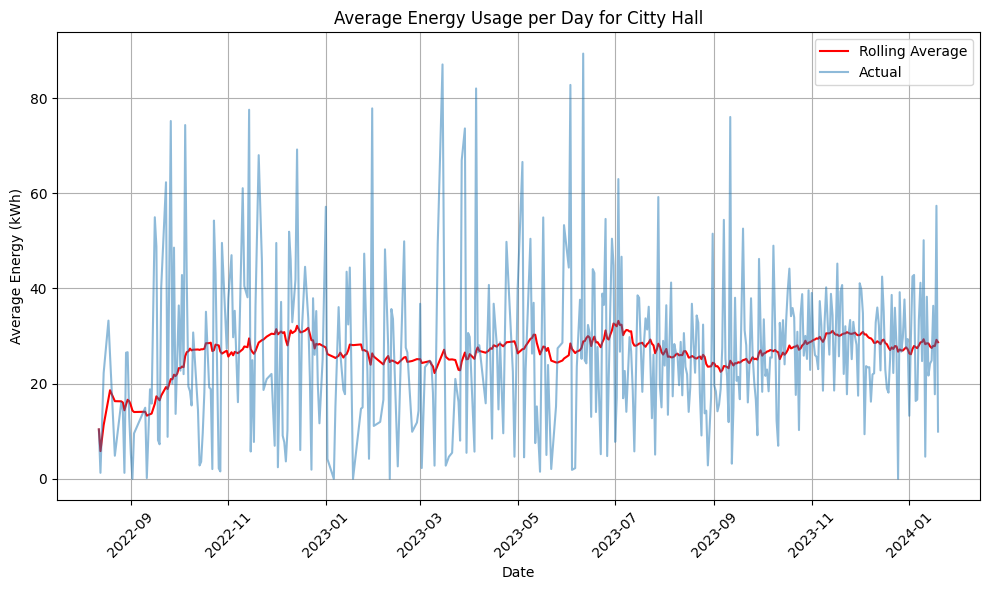

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


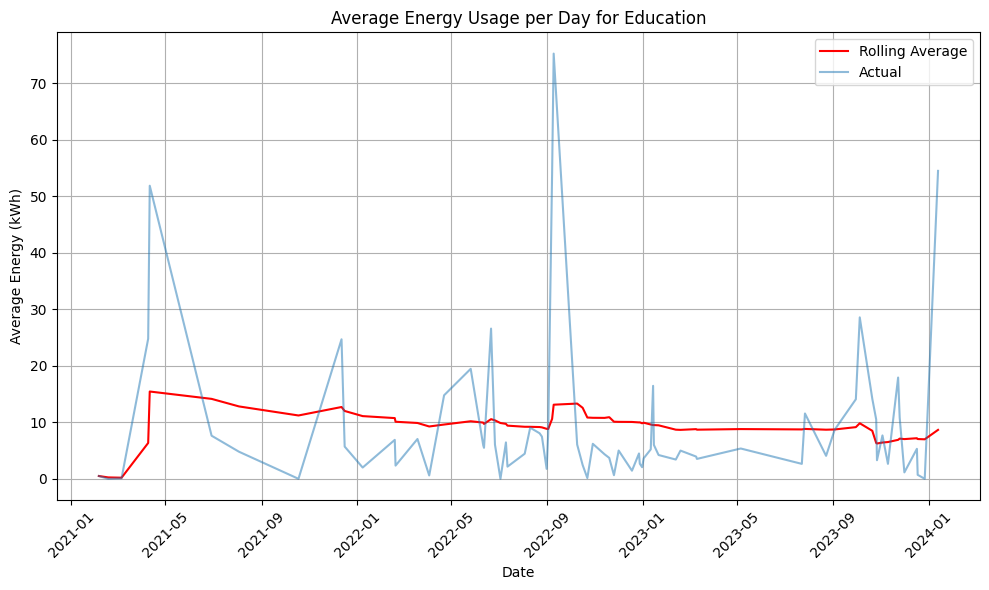

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


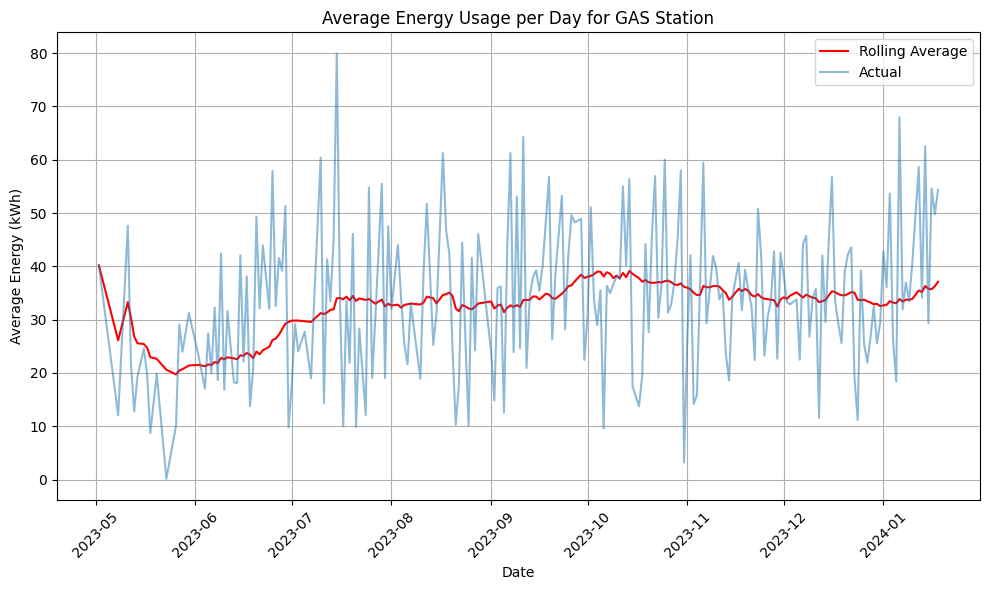

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


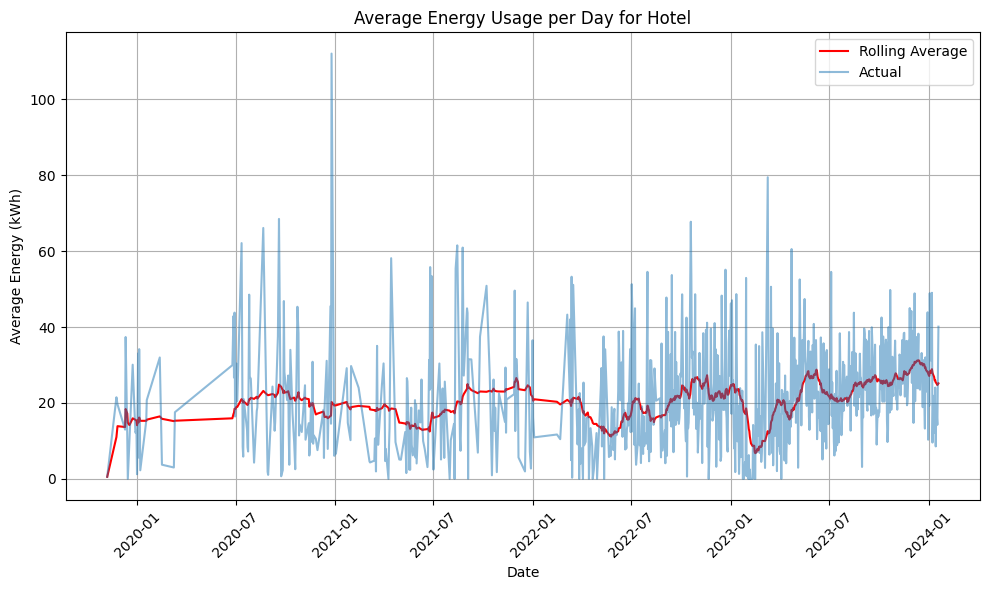

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


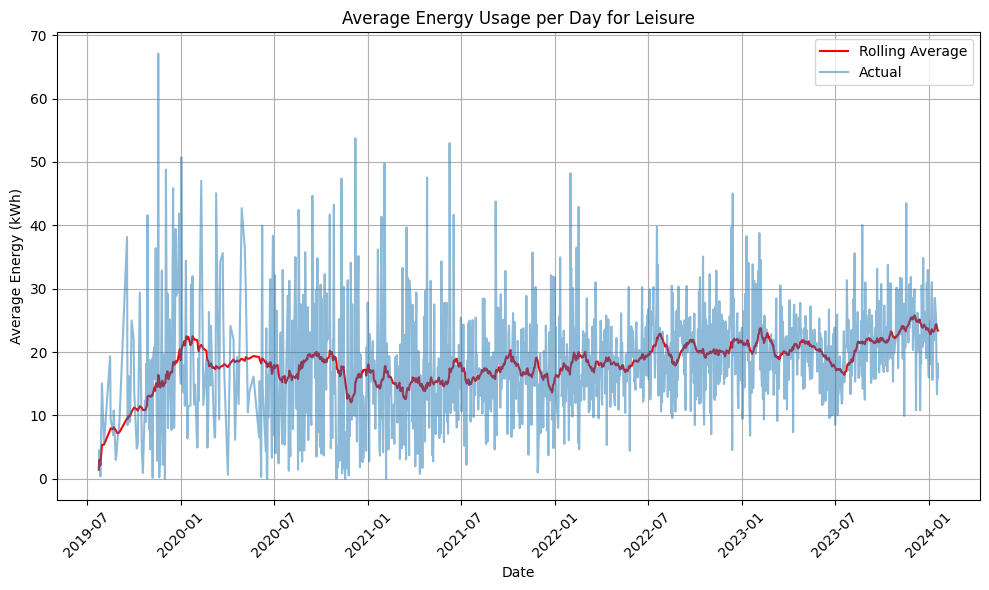

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


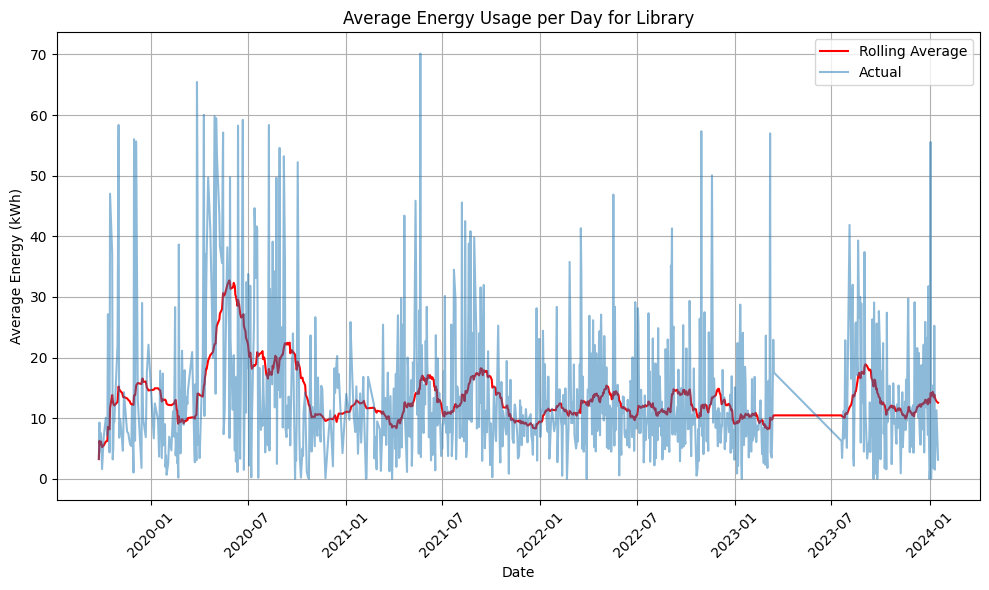

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


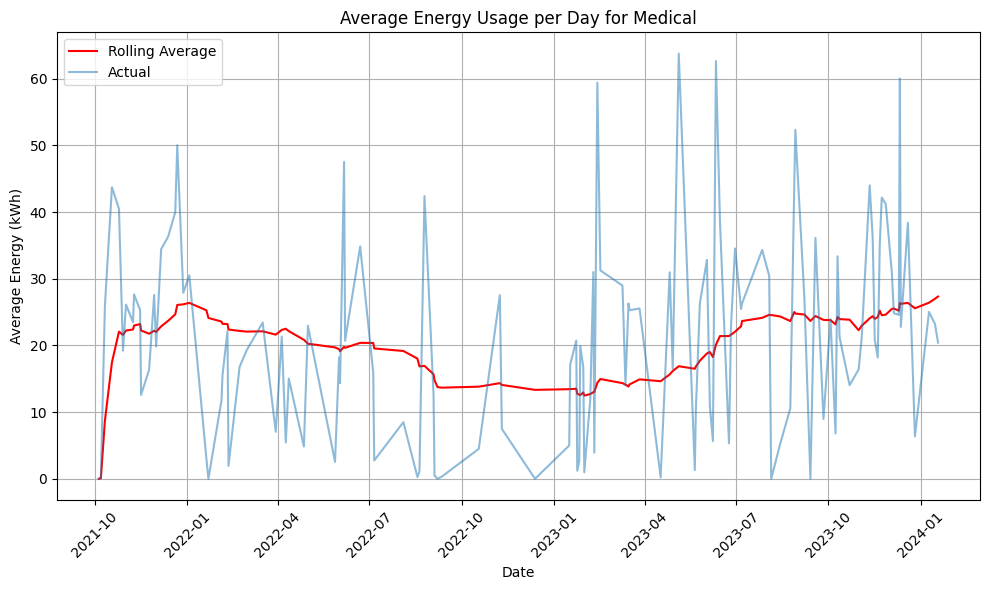

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


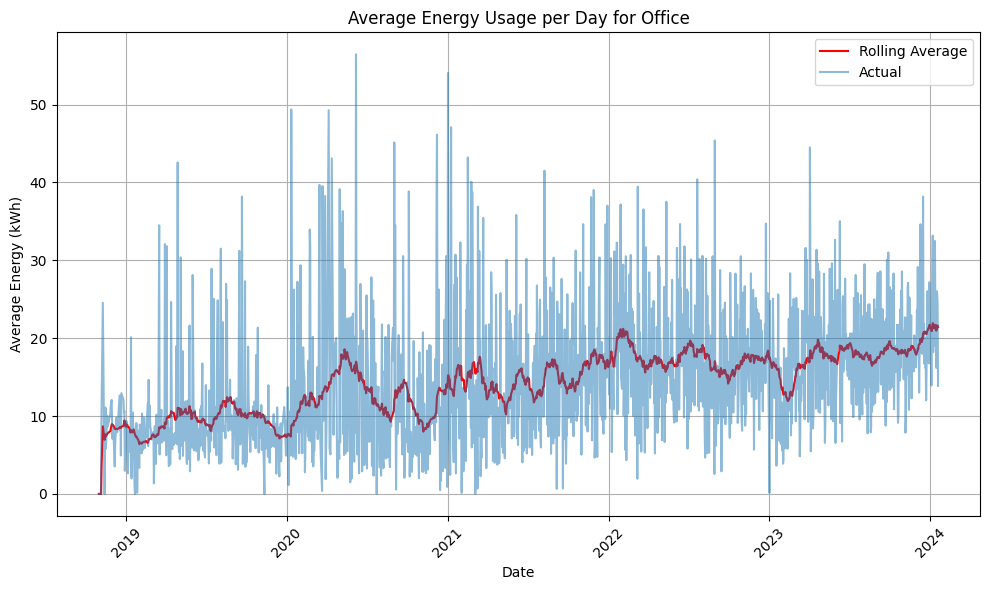

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


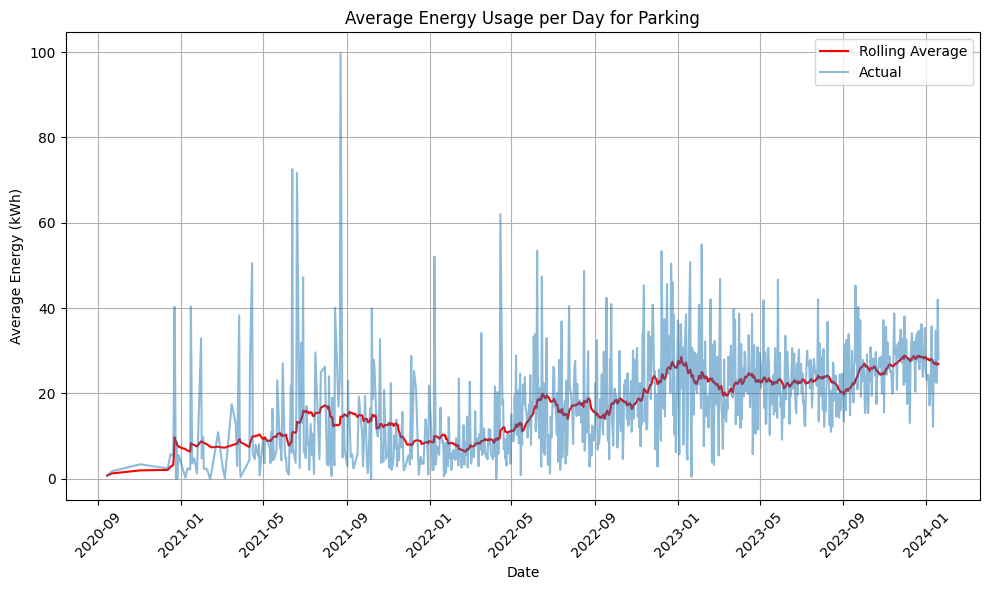

<ipython-input-51-5f58bc61515f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


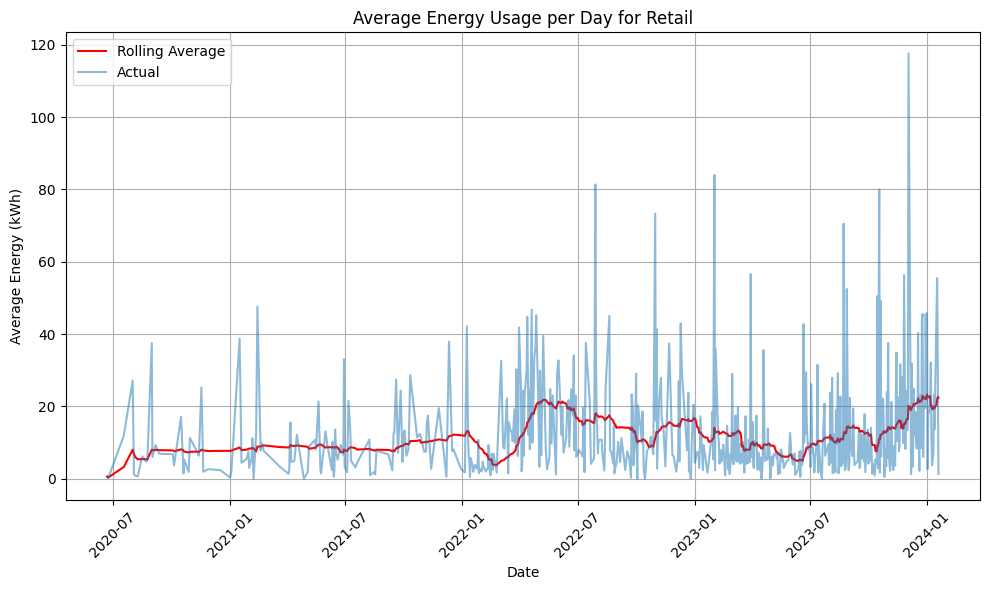

In [ ]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])

df['Date'] = df['Start_Time_EST'].dt.date

# Group by venue and date, and calculate average energy per day for each venue
venue_utilization_data = df.groupby(['Charging Venue', 'Date'])['Energy (kWh)'].mean().reset_index()

# Plot for each venue with a rolling average
venues = venue_utilization_data['Charging Venue'].unique()

for venue in venues:
    plt.figure(figsize=(10, 6))
    venue_data = venue_utilization_data[venue_utilization_data['Charging Venue'] == venue]

    # Calculate a 30-day rolling average for smoother trend
    venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()

    plt.plot(venue_data['Date'], venue_data['Rolling Average'], label='Rolling Average', color='red')
    plt.plot(venue_data['Date'], venue_data['Energy (kWh)'], label='Actual', alpha=0.5)

    plt.title(f'Average Energy Usage per Day for {venue}')
    plt.xlabel('Date')
    plt.ylabel('Average Energy (kWh)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




utilization_station_data['Date'] = pd.to_datetime(utilization_station_data['Date'])


utilization_station_data = utilization_station_data.sort_values(by=['EVSE ID', 'Date'])

evse_ids = utilization_station_data['EVSE ID'].unique()

# Create a plot for each EVSE ID
for evse_id in evse_ids:
    # Filter data for current EVSE ID
    evse_data = utilization_station_data[utilization_station_data['EVSE ID'] == evse_id]
    
    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(evse_data['Date'], evse_data['Energy (kWh)'], linestyle='-')
    plt.title(f'Daily Energy Usage for EVSE ID {evse_id}')
    plt.xlabel('Date')
    plt.ylabel('Energy (kWh)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:

utilization_station_data



NameError: name 'utilization_station_data' is not defined

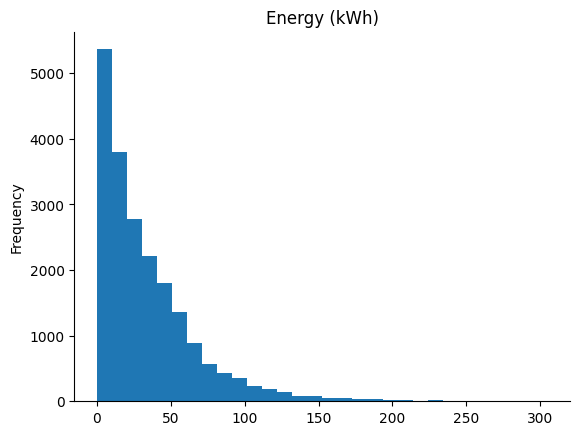

In [ ]:
# @title Energy (kWh)

utilization_station_data['Energy (kWh)'].plot(kind='hist', bins=30, title='Energy (kWh)')
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-22-51ba0cadedba>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




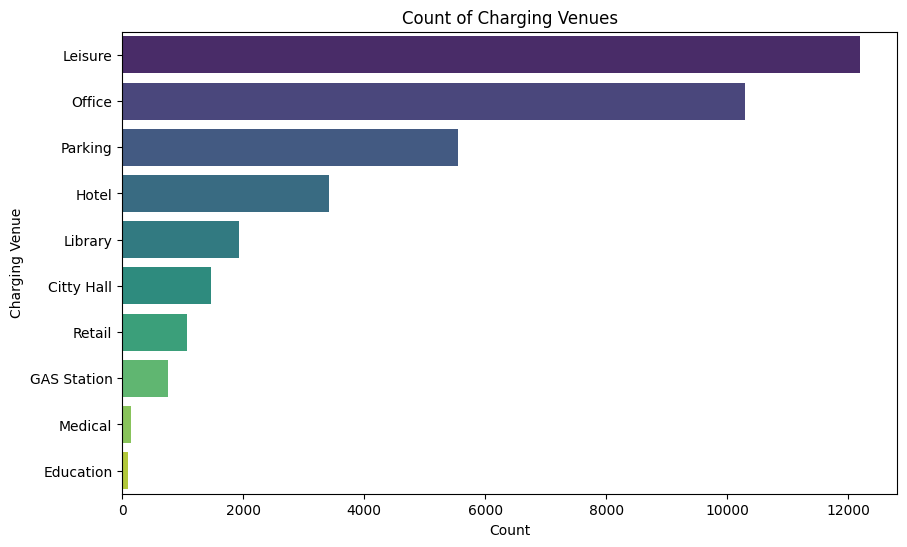

In [ ]:

# Group by EVSE ID and calculate the count for each charging venue category
# df_evse_category = df.groupby(['EVSE ID', 'Charging Venue']).size().unstack(fill_value=0)

venue_counts = df['Charging Venue'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=venue_counts.values, y=venue_counts.index, palette='viridis')

plt.xlabel('Count')
plt.ylabel('Charging Venue')
plt.title('Count of Charging Venues')
plt.show()

In [ ]:
df.columns

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Zip/Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency',
       'Fee', 'Ended By', 'Plug In Event ID', 'Transaction ID',
       'Driver Zip/Postal Code', 'User ID', 'Start SOC', 'End SOC', 'County',
       'System S/N', 'Model Number', 'OnRamp ID Tag',
       'Payment Terminal Session ID', 'Vehicle MAC ID', 'Start_Time_EST',
       'End_Time_EST', 'Total Duration', 'Charging Time', 'parking_time',
       'End_Charging_Time_EST', 'Day_of_Week', 'Is_Weekday', 'Is_Weekend',
       'DC', 'L2', 'previous_end_time', 'idle', 'idle_hour', 'idle_day',
       'SOC_diff', 'Servi

In [ ]:

map_osm = folium.Map(location=[df_TN['Latitude'].mean(), df['Longitude'].mean()], zoom_start=10)

marker_cluster = MarkerCluster().add_to(map_osm)
for idx, row in df_TN.groupby('EVSE ID').first().iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']],
                  popup=f"EVSE ID: {idx}\nLatitude: {row['Latitude']}\nLongitude: {row['Longitude']}").add_to(marker_cluster)

map_osm


In [ ]:
df_tn_reg['Registration Date'] = pd.to_datetime(df_tn_reg['Registration Date'])
df_tn_reg=df_tn_reg.sort_values(by=['Registration Date', 'County','Vehicle Model Year'])


In [ ]:
df_tn_reg.columns

Index(['State', 'County', 'Registration Date', 'Vehicle Make', 'Vehicle Model',
       'Vehicle Model Year', 'Drivetrain Type', 'Vehicle GVWR Class',
       'Vehicle Category', 'Vehicle Count', 'DMV Snapshot ID',
       'DMV Snapshot (Date)', 'Latest DMV Snapshot Flag'],
      dtype='object')

In [ ]:

df_tn_reg['Registration Date'] = pd.to_datetime(df_tn_reg['Registration Date'])

grouped_data_tn = df_tn_reg.groupby([pd.Grouper(key='Registration Date', freq='M'), 'County'])['Vehicle Count'].sum().reset_index()

result_df = pd.DataFrame({
    'Month': grouped_data_tn['Registration Date'],
    'County': grouped_data_tn['County'],
    'Total Registered ElVehicles': grouped_data_tn['Vehicle Count']
})

fig = px.scatter(result_df,

                 x='Month',
                 y='Total Registered ElVehicles',
                 color='County')

fig.update_layout(
    title='TN Registered EV by County (3 Month int)',
    xaxis_title='Year',
    yaxis_title='Number of registered EV',
)
fig.show()


In [ ]:

county_vehicle_counts = df_tn_reg.groupby('County')['Vehicle Count'].sum().reset_index()

# Create the bar chart
fig = px.bar(county_vehicle_counts,
             x='County',
             y='Vehicle Count',
             title='Total Number of Registered EV by County',
             labels={'County': 'TN County', 'Vehicle Count': 'Total Registered Vehicles'})

fig.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_tn_population = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/tennessee_counties_population.csv')
df_tn_population['County'] = df_tn_population['County'] + ' County'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
county_vehicle_counts = df_tn_reg.groupby('County')['Vehicle Count'].sum().reset_index()

merged_df = pd.merge(df_tn_population, county_vehicle_counts, on='County')


In [ ]:
merged_df['2020 Population'] = merged_df['2020 Population'].str.replace(',', '')
merged_df['2020 Population'] = merged_df['2020 Population'].astype('int64')

In [ ]:
merged_df['percentage of poulation']=(merged_df['Vehicle Count']*100)/merged_df['2020 Population']

In [ ]:
merged_df

,County,1990 Population,2000 Population,2010 Population,2020 Population,Vehicle Count,percentage of poulation
0,Anderson County,"68,250","71,330","75,129",77123,3785,4.907745
1,Bedford County,"30,411","37,586","45,058",50237,1032,2.054263
2,Benton County,"14,524","16,537","16,489",15864,163,1.027484
3,Bledsoe County,"9,669","12,367","12,876",14913,179,1.200295
4,Blount County,"85,969","105,823","123,010",135280,4832,3.571851
...,...,...,...,...,...,...,...
90,Wayne County,"13,935","16,842","17,021",16232,204,1.256777
91,Weakley County,"31,972","34,895","35,021",32902,306,0.930035
92,White County,"20,090","23,102","25,841",27351,397,1.451501
93,Williamson County,"81,021","126,638","183,182",247726,70360,28.402348


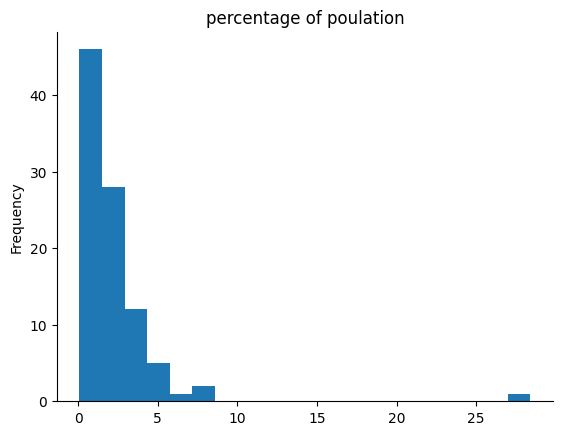

In [ ]:
merged_df['percentage of poulation'].plot(kind='hist', bins=20, title='percentage of poulation')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_venue

,Station Name,EVSE ID,Charging Venue,Org Name,Address 1,City,State/Province,Zip/Postal Code,Latitude (y),Longitude (x)
0,TVPPA 7SPC / CORP OFFICE,682921,Office,TVPPA & 7SPC,1210 Broad Street,Chattanooga,Tennessee,37402,35.040119,-85.309135
1,TVPPA 7SPC / HOLSTON CONNECT,1785631,Office,TVPPA & 7SPC,1200 W Main St,Rogersville,Tennessee,37857,36.400318,-83.018478
2,7SPC / COLUMBUS MS,1844191,Leisure,TVPPA & 7SPC,322 Main St,Columbus,Mississippi,39701,33.494743,-88.429993
3,7SPC / STARKVILLE DWTN,1921351,Office,Seven States Power Corp,135 Jefferson St,Starkville,Mississippi,39759,33.464867,-88.814087
4,7SPC / STARKVILLE REC,1921531,Leisure,Seven States Power Corp,405 Lynn Ln,Starkville,Mississippi,39759,33.441540,-88.829910
...,...,...,...,...,...,...,...,...,...,...
88,HOLSTONELECTRIC / CHURCH HILL-2,14337501,Office,Holston Electric Cooperative Inc,219 S Central Ave,Church Hill,Tennessee,37642,36.517448,-82.707474
89,HARTSELLE 1 / STATION 2 (R),14355251,Parking,Hartselle Utilities,214 Chestnut St NW,Hartselle,Alabama,35640,34.443974,-86.935577
90,SES-TN / STATION 2,15250701,Parking,Smithville Electric System,106 N 3rd Street,Smithville,Tennessee,37166,35.961960,-85.812782
91,SES-TN / STATION 1,15250771,Parking,Smithville Electric System,106 N 3rd Street,Smithville,Tennessee,37166,35.962025,-85.812798
